<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/dmi_04_pollution_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Pollution Data Clustering

**Data Source:** This dataset comes from [Kaggle's Global Air Pollution Dataset](https://www.kaggle.com/datasets/hasibalmuzdadid/global-air-pollution-dataset).

We will use K-Means clustering on a global air pollution dataset to identify highly polluted areas.
The dataset contains information on various pollutants such as CO, Ozone, NO2, and PM2.5 for different cities around the world.

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import MarkerCluster

from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/updated_air_pollution_dataset.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/updated_air_pollution_dataset.csv'  # Local path

Mounted at /content/drive


In [3]:
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)

Dataset shape: (17900, 14)


In [4]:
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,Latitude,Longitude
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,NaN,NaN
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-11.295918,-41.987157
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.157930,15.186029
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.019022,20.880403
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good,-17.592920,-149.606367


In [5]:
pollutant_cols = ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

df[pollutant_cols] = df[pollutant_cols].fillna(0)

df[pollutant_cols].describe()

,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,17900.000000,17900.000000,17900.000000,17900.000000
mean,1.367095,35.082067,3.071117,68.798045
std,1.882652,27.833147,5.290206,54.857521
min,0.000000,0.000000,0.000000,2.000000
25%,1.000000,21.000000,0.000000,35.000000
50%,1.000000,30.500000,1.000000,54.000000
75%,1.000000,40.000000,4.000000,79.000000
max,133.000000,235.000000,91.000000,500.000000


In [6]:
# Standardise the pollutant columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[pollutant_cols] = scaler.fit_transform(df_scaled[pollutant_cols])
print("Scaled pollutant values (first 5 rows):")
df_scaled[pollutant_cols].head()

Scaled pollutant values (first 5 rows):


,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,-0.194994,0.032981,-0.580545,-0.324450
1,-0.194994,-1.080830,-0.391511,-0.506746
2,-0.194994,0.140769,-0.202477,-0.051007
3,-0.194994,-0.038878,-0.580545,-0.889566
4,-0.726174,-0.470031,-0.580545,-1.144780


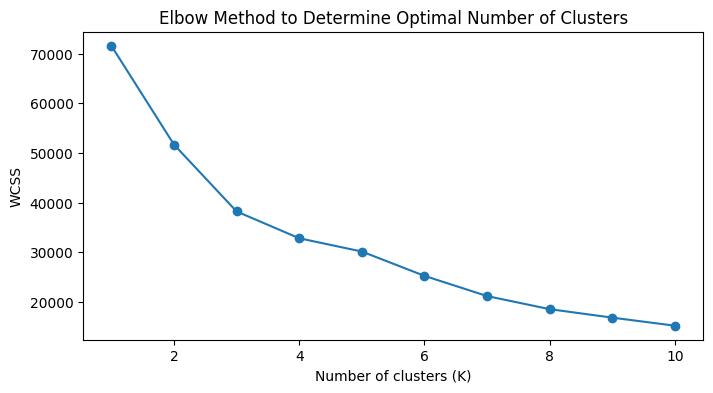

In [7]:
wcss = []
for k in range(1, 11):
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_temp.fit(df_scaled[pollutant_cols])
    wcss.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method to Determine Optimal Number of Clusters")
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS")
plt.show()

In [8]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[pollutant_cols])
print("Cluster distribution:")
df_scaled['Cluster'].value_counts()

Cluster distribution:


,count
Cluster,
1,14311
0,1619
3,1201
2,769


In [9]:
cluster_summary = df_scaled.groupby('Cluster')[pollutant_cols].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
Cluster                                                               
0            0.117022         0.278961      -0.232718         1.897855
1           -0.203828        -0.178895      -0.210178        -0.379021
2            1.020712         3.869436      -0.088418         1.561964
3            1.617477        -0.721955       2.874792         0.957857


In [14]:
df_scaled = df_scaled.dropna(subset=['Latitude', 'Longitude'])

world_map = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(world_map)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']

for idx, row in df_scaled.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['City']}, {row['Country']}<br>Cluster: {row['Cluster']}<br>CO: {row['CO AQI Value']:.2f}",
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(marker_cluster)

world_map.save("air_pollution_clusters_map.html")
print("Map has been saved as 'air_pollution_clusters_map.html'.")


Map has been saved as 'air_pollution_clusters_map.html'.
